In [ ]:
import os
import pickle
import re
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.efficientnet import EfficientNetB7, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import LSTM, Dropout, add, Dense, Input, Embedding,concatenate,Reshape

In [ ]:
os.chdir("/content/drive/MyDrive/Captioned_Images")
root = os.getcwd()

In [ ]:
efficientnetB7_model = EfficientNetB7()
efficientnetB7_model = Model(inputs = efficientnetB7_model.inputs,outputs= efficientnetB7_model.layers[-2].output)

In [ ]:
print(efficientnetB7_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 600, 600, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 600, 600, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 600, 600, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 600, 600, 3)          0         ['normalization_2[0][0]'

In [ ]:
#extract features from image with EfficientNetB7
#features is dict (image_id as key and features as value)
features = dict()
images_directory = os.path.join(root,"Images")
for img_name in tqdm(os.listdir(images_directory)):
  img_path = images_directory + "/" + img_name
  image = load_img(img_path,target_size=(600,600))
  image = img_to_array(image)
  image = np.expand_dims(image,axis=0)
  image = preprocess_input(image)
  feature = efficientnetB7_model.predict(image,verbose=0)
  img_id = img_name.split(".")[0]
  features[img_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
len(features)

8091

In [ ]:
#store features in pickle
pickle.dump(features,open(os.path.join(root,"features","efficientnetB7_model_features.pkl"),"wb"))

In [ ]:
#load features from pickle
with open(os.path.join(root,"features","efficientnetB7_model_features.pkl"),"rb") as f:
  features = pickle.load(f)

In [ ]:
len(features)

8091

In [ ]:
with open("captions.txt","r") as f:
  next(f)
  captions = f.read()

In [ ]:
captions

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [ ]:
#create mapping  of image to captions
mapping = dict()
for line in tqdm(captions.split("\n")):
  tokens = line.split(",")
  if len(line)<2:
    continue
  image_id, caption = tokens[0].split(".")[0], " ".join(tokens[1:])
  if image_id not in mapping:
    mapping[image_id] = list()
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
mapping["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def preprocess_captions(mappingg):
  for key,captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      caption = caption = re.sub(r"[^A-Za-z]+"," ",caption) # remove all special character and digit
      caption = caption = re.sub(r"\s+"," ",caption) # convert multiple white spaces to one white space
      caption = "startseq " + " ".join(word for word in caption.split() if len(word) > 1) + " endseq"
      captions[i] = caption

In [ ]:
#before preprocess of captions
mapping["1001773457_577c3a7d70"]

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
preprocess_captions(mapping)

In [ ]:
#after preprocess of captions
mapping["1001773457_577c3a7d70"]

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# Create Tokenizer and Vocab
all_captions = list()
for key,captions in mapping.items():
  for caption in captions:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8427

In [ ]:
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'shirt': 35,
 'down': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'front': 47,
 'sitting': 48,
 'holding': 49,
 'up': 50,
 'field': 51,
 'small': 52,
 'by': 53,
 'large': 54,
 'green': 55,
 'one': 56,
 'group': 57,
 'yellow': 58,
 'her': 59,
 'walking': 60,
 'children': 61,
 'men': 62,
 'into': 63,
 'air': 64,
 'beach': 65,
 'near': 66,
 'mouth': 67,
 'jumps': 68,
 'another': 69,
 'for': 70,
 'street': 71,
 'runs': 72,
 'its': 73,
 'from': 74,
 'riding'

In [ ]:
#get maximum length of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
#split data to train, validation, test sets
image_ids = list(mapping.keys())
train_split = int(len(image_ids) * 0.90)
validation_split = int(len(image_ids) * 0.05)
train = image_ids[:train_split]
validation = image_ids[train_split:train_split+validation_split]
test = image_ids[train_split+validation_split:]

print(len(train), len(validation), len(test))

7281 404 406


In [ ]:
#create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n +=1
      captions = mapping[key]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1,len(seq)):
          in_seq, out_seq = seq[:i],seq[i]
          in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
          out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)

      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1,X2], y
        X1, X2, y = list(), list(), list()
        n = 0

In [ ]:
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, 1)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 2560)
(47, 35)
(47, 8427)


In [ ]:
input1 = Input(shape=(2560,))

img_features = Dense(256,activation="relu")(input1)
img_features_reshaped = Reshape((1,256),input_shape=(256,))(img_features)

input2 = Input(shape=(max_length,))
sentence_features = Embedding(vocab_size,256,mask_zero=False)(input2)

merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features1 = LSTM(256,return_sequences=True)(merged)
sentence_features = LSTM(256)(sentence_features1)
x=Dropout(0.5)(sentence_features)
x=add([x,img_features])
x=Dense(128,activation="relu")(x)
x=Dropout(0.5)(x)
output = Dense(vocab_size,activation="softmax")(x)

model = Model(inputs=[input1,input2],outputs=output)

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

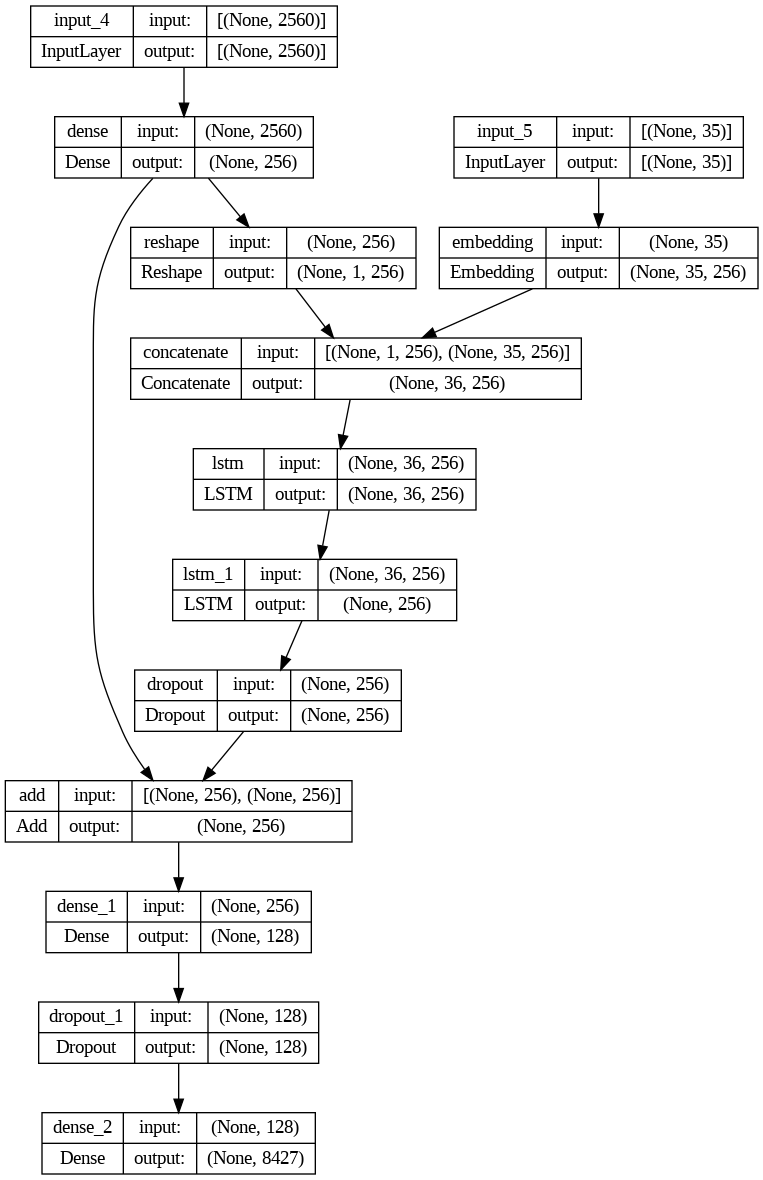

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 2560)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  655616    ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [ ]:
epochs = 20
batch_size = 32
steps_per_epoch = len(train) // batch_size

train_data_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
validation_data_generator = data_generator(validation, mapping, features, tokenizer, max_length, vocab_size, batch_size)

history = model.fit(train_data_generator,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_data=validation_data_generator,
          validation_steps=len(validation) // batch_size,
          verbose=1,)

Epoch 1/20
227/227 [==============================] - 69s 267ms/step - loss: 5.7676 - accuracy: 0.0979 - val_loss: 5.0634 - val_accuracy: 0.1475
Epoch 2/20
227/227 [==============================] - 58s 255ms/step - loss: 4.9339 - accuracy: 0.1610 - val_loss: 4.5064 - val_accuracy: 0.2073
Epoch 3/20
227/227 [==============================] - 59s 258ms/step - loss: 4.4540 - accuracy: 0.2086 - val_loss: 4.1684 - val_accuracy: 0.2447
Epoch 4/20
227/227 [==============================] - 46s 201ms/step - loss: 4.1721 - accuracy: 0.2349 - val_loss: 3.9960 - val_accuracy: 0.2668
Epoch 5/20
227/227 [==============================] - 47s 207ms/step - loss: 3.9796 - accuracy: 0.2547 - val_loss: 3.8660 - val_accuracy: 0.2842
Epoch 6/20
227/227 [==============================] - 45s 198ms/step - loss: 3.8353 - accuracy: 0.2683 - val_loss: 3.7866 - val_accuracy: 0.2933
Epoch 7/20
227/227 [==============================] - 45s 198ms/step - loss: 3.7247 - accuracy: 0.2790 - val_loss: 3.7559 - val_ac

In [ ]:
model.save(os.path.join(root,"best_models","Encoder_Decoder_Architecture","EfficientNetB7_2LSTM_NEW_MERGE_MODLE.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def idx_to_word(idx,tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == idx:
      return word
  return None

In [ ]:
def predict_caption(model,image,tokenizer,max_length):
  in_text = "startseq"
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence],max_length)
    yhat = model.predict([image,sequence],verbose=0)
    yhat = np.argmax(yhat)
    word = idx_to_word(yhat,tokenizer)
    if word is None:
      break
    in_text +=" " + word
    if word == "endseq":
      break
  return in_text

In [ ]:
actual, predicted = list(), list()

for key in tqdm(test):
  captions = mapping[key]
  y_pred = predict_caption(model,features[key],tokenizer,max_length)
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted))

  0%|          | 0/406 [00:00<?, ?it/s]

BLEU-1: 0.617806
BLEU-2: 0.389335
BLEU-3: 0.252382
BLEU-4: 0.157618


In [ ]:
def generate_caption(img_name):
  img_id = img_name.split(".")[0]
  img_path = os.path.join(root,"Images",img_name)
  image = Image.open(img_path)
  captions = mapping[img_id]
  print("----------------Actual----------------")
  for caption in captions:
    print(caption)

  y_pred = predict_caption(model,features[img_id],tokenizer,max_length)
  print("----------------Predicted----------------")
  print(y_pred)
  plt.imshow(image)
  plt.axis("off")

In [ ]:
test[:5]

['537479916_c033897fac',
 '537532165_e4b7c0e61a',
 '537559285_29be110134',
 '537579448_a7f92cef58',
 '537628742_146f2c24f8']

----------------Actual----------------
startseq black dog finishes running down blue and orange ramp endseq
startseq black dog has just run down blue and red ramp on an obstacle course endseq
startseq dog and person doing an agility course endseq
startseq dog runs dog ramp endseq
startseq dog runs down ramp past its trainer endseq
----------------Predicted----------------
startseq dog jumps over hurdle endseq


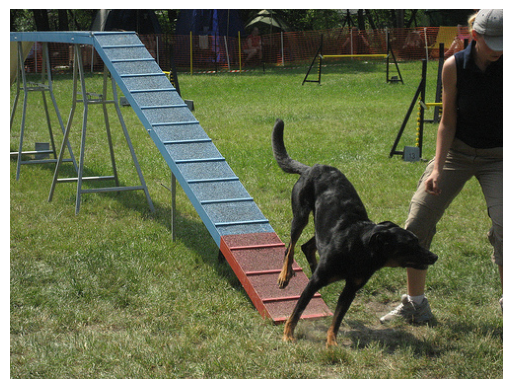

In [ ]:
generate_caption("537479916_c033897fac.jpg")

----------------Actual----------------
startseq child playing on the monkey bars at playground with an adult present endseq
startseq girl hangs on the bars endseq
startseq kid hangs upside down on the monkey bars at playground endseq
startseq young children hanging upside at the playground endseq
startseq girl hanging upside down on blue monkey bars endseq
----------------Predicted----------------
startseq two children are playing on playground endseq


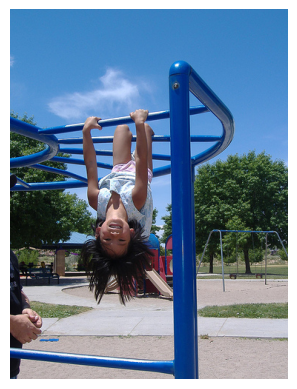

In [ ]:
generate_caption("537532165_e4b7c0e61a.jpg")

----------------Actual----------------
startseq brown and white sheltie leaping over rail endseq
startseq collie is running through an obstacle course endseq
startseq collie jumping over training hurdle that is on the grass endseq
startseq collie making jump over yellow hurdle endseq
startseq the dog is leaping over hurdle endseq
----------------Predicted----------------
startseq dog jumping over hurdle endseq


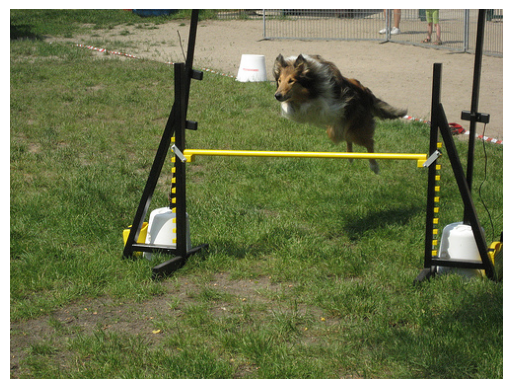

In [ ]:
generate_caption("537559285_29be110134.jpg")

----------------Actual----------------
startseq little girl in pink hat is playing with soccer ball endseq
startseq young girl is playing with soccer ball in the grass endseq
startseq little girl with pink hat playing with soccer ball endseq
startseq the little girl wearing pink hat is bending down to pick up soccer ball endseq
startseq young child playing with soccer ball in grassy area endseq
----------------Predicted----------------
startseq two children are playing in the grass endseq


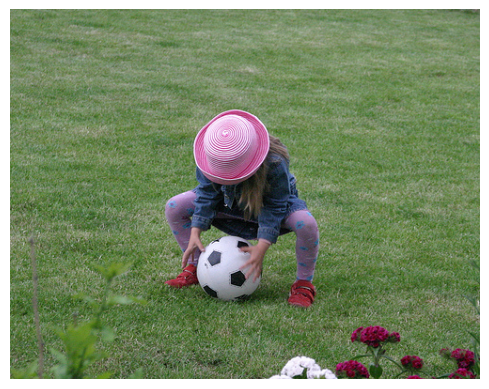

In [ ]:
generate_caption("537579448_a7f92cef58.jpg")

----------------Actual----------------
startseq little girl running in field endseq
startseq little girl walking on the green grass in front of big stone endseq
startseq small child is in grassy field near an old structure endseq
startseq small child running along the grass with large pilar in the background endseq
startseq young child walks on the grass away from stone monument endseq
----------------Predicted----------------
startseq woman in red shirt is standing on the ground in the grass endseq


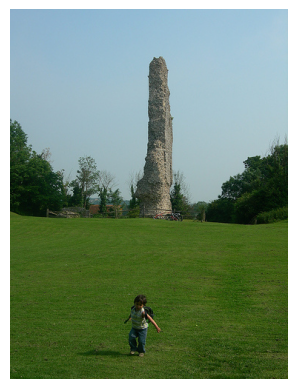

In [ ]:
generate_caption("537628742_146f2c24f8.jpg")

In [ ]:
def generate_caption_outof_dataset(img_name):
  image = Image.open(img_name)
  img = load_img(img_name,target_size=(224,224))
  img = img_to_array(img)
  img = np.expand_dims(img,axis=0)
  img = preprocess_input(img)
  feature = efficientnetB7_model.predict(img,verbose=0)
  y_pred = predict_caption(model,feature,tokenizer,max_length)
  print(y_pred)
  plt.imshow(image)
  plt.axis("off")

startseq two people are walking on the beach on the beach endseq


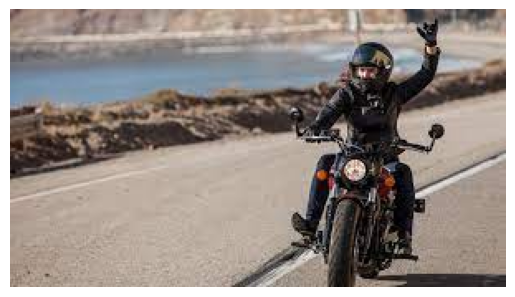

In [ ]:
generate_caption_outof_dataset("indir.jpeg")